We start by loading necessary packages, loading the Open Specy metadata ('OS_metadata') and 1st-derivative spectra ('der_spectra') and by defining some basic utility functions. The derivative spectra are generated by data_arrange.py

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy.cluster.hierarchy as hy
import matplotlib.pyplot as plt
from collections import Counter

OS_metadata = pd.read_csv('reference_absorbance_raw_metadata.csv', encoding='latin1')
der_spectra = pd.read_csv('open_specy_reference_FTIR_DERINT.csv')
OS_library = pd.read_csv('reference_absorbance_raw.csv')

OS_metadata = OS_metadata[OS_metadata['SpectrumType']=='FTIR']

der_spectra = der_spectra.dropna(how='any')

def norm_pearson(p,q):
    modp = p/(np.max(p) - np.min(p))
    modq = q/(np.max(q) - np.min(q))
    return stats.pearsonr(modp,modq)[0]

def deriv(p, w):
    return p - np.roll(p,w)

def integ(p):
    return [np.sum(p[:k]) for k in range(1,len(p)+1)]
    
smoothing_window = 7

C:\Users\Shreyas.Patankar\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (31,32,33,34,35,36,37,38,39,40,41,42,53,54,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,82,84,86,88,89,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We then convert spectral data to an array after ignoring a small window from 900-950 cm<sup>-1</sup>. To avoid numerical errors, any 0.00 entries are replaced by a small random number instead.

In [2]:
X = np.transpose(der_spectra.iloc[:,1:].to_numpy())

def add_noise(x):
    if np.abs(x) > 10**(-14):
        return x
    else: return np.random.random_sample()*10**(-15)

nt = np.vectorize(add_noise)
Xp = nt(X)

And then apply the SciPy heirarchical clustering model to obtain a "linkage matrix" Z

In [3]:

Z = hy.linkage(Xp, method='average', metric='correlation', optimal_ordering=True)

A dendrogram like the one below is an easy way to visualize the results of the clustering.

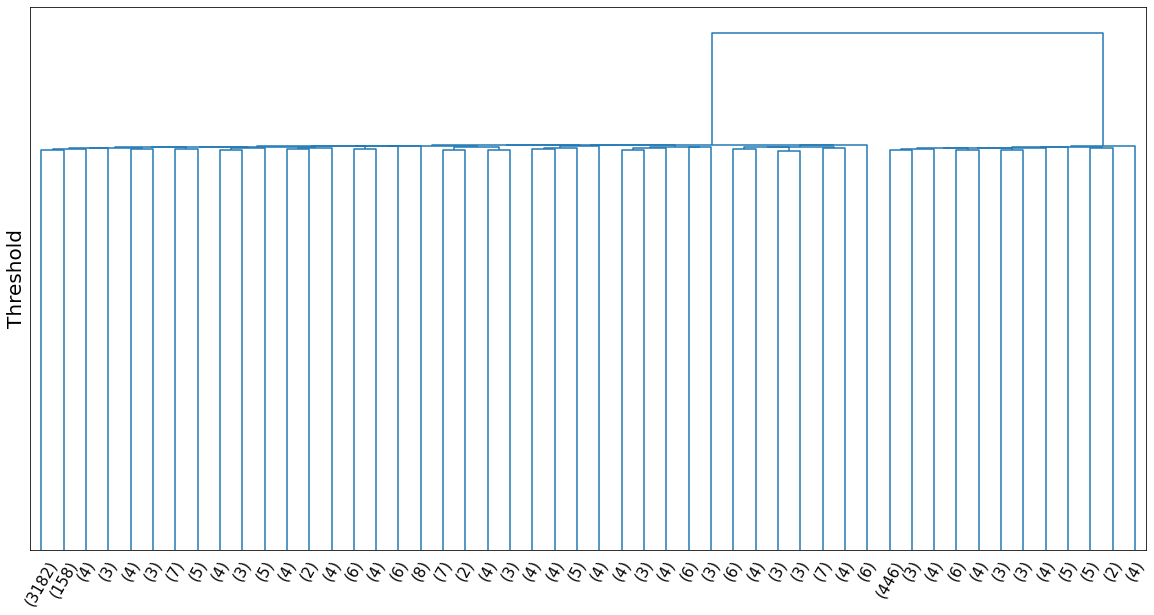

In [4]:
fig, axs = plt.subplots(figsize=(20,10))
R = hy.dendrogram(Z, p=50, truncate_mode='lastp', get_leaves=True, count_sort='descending', ax=axs)
axs.set_yticks([])
axs.set_ylabel('Threshold', fontsize=20)
axs.tick_params(axis='x', labelsize=15, labelrotation = 60)
plt.show()

from the linkage matrix Z, we generate clusters with threshold 0.7 or less - that is equivalent to a relative pearson correlation of 0.3 or greater. 'clust_ix_raw' is a list of cluster labels obtained with this method applied to each of the 636 spectra. Aesthetically it is preferable to have lower cluster labels for most commonly found spectra, so we re-order the 'raw' labels by popularity into a new cluster label list 'cluster_ix'. We then append these labels to the OS_metadata, and save a new metadata file with cluster labels

In [5]:
clust_ix_raw = hy.fcluster(Z,t=.7,criterion='distance')
d = Counter(clust_ix_raw)
pop_clusts = [k[0] for k in sorted(d.items(), key=lambda x: x[1], reverse=True)]
clust_dict = dict(zip(pop_clusts,range(1,len(d)+1)))
clust_ix = np.array([clust_dict[k] for k in clust_ix_raw])

OS_metadata['clust_ix'] = clust_ix
OS_metadata.to_csv('ftir_metadata_clusters_raw.csv', index=False)
#OS_metadata[['spectrum_identity','sample_name','clust_ix']]

For every cluster, we calculate the mean and standard deviation of the (integrated) spectrum to enable better visual comparison

In [13]:
cl_means = []
cl_stds = []

for ix in range(1,len(d)+1):
    cl_array = np.empty((0,len(der_spectra['wavenos'])))
    for k in OS_metadata[OS_metadata['clust_ix']==ix]['sample_name']:
        cl_array = np.vstack([cl_array,np.array(der_spectra[str(k)])])
    cl_array = np.apply_along_axis(integ,1,cl_array)
    cl_means.append(cl_array.mean(axis=0))
    cl_stds.append(cl_array.std(axis=0))

#cl_array = np.empty((0,len(der_spectra['wavenos'])))
#for k in OS_metadata[OS_metadata['clust_ix']==4]['sample_name']:
#    cl_array = np.vstack([cl_array,np.array(der_spectra[k])])
#cl_means.append(integ(cl_array.mean(axis=0)))
#cl_stds.append(integ(cl_array.std(axis=0)))
#plt.plot(der_spectra['wavenos'],cl_means[0])

New spreadhseet 'cluster_keys_raw' is exported for simplified category names to be entered using expert human judgement

In [11]:
cluster_keys = pd.DataFrame()
cluster_keys['cluster_index'] = range(1,len(d)+1)

cl_names = []
#threshold = .3 
for ix in range(1,len(d)+1):
    #cl_array = np.empty((0,len(der_spectra['wavenos'])))
    cl_names.append(OS_metadata[OS_metadata['clust_ix']==ix]['SpectrumIdentity'].values)

cluster_keys['SpectrumIdentities'] = cl_names

cluster_keys.set_index('cluster_index')

cluster_keys.to_csv('cluster_keys_raw.csv', index=False)

We plot the mean for the top 50 clusters for visual aid.

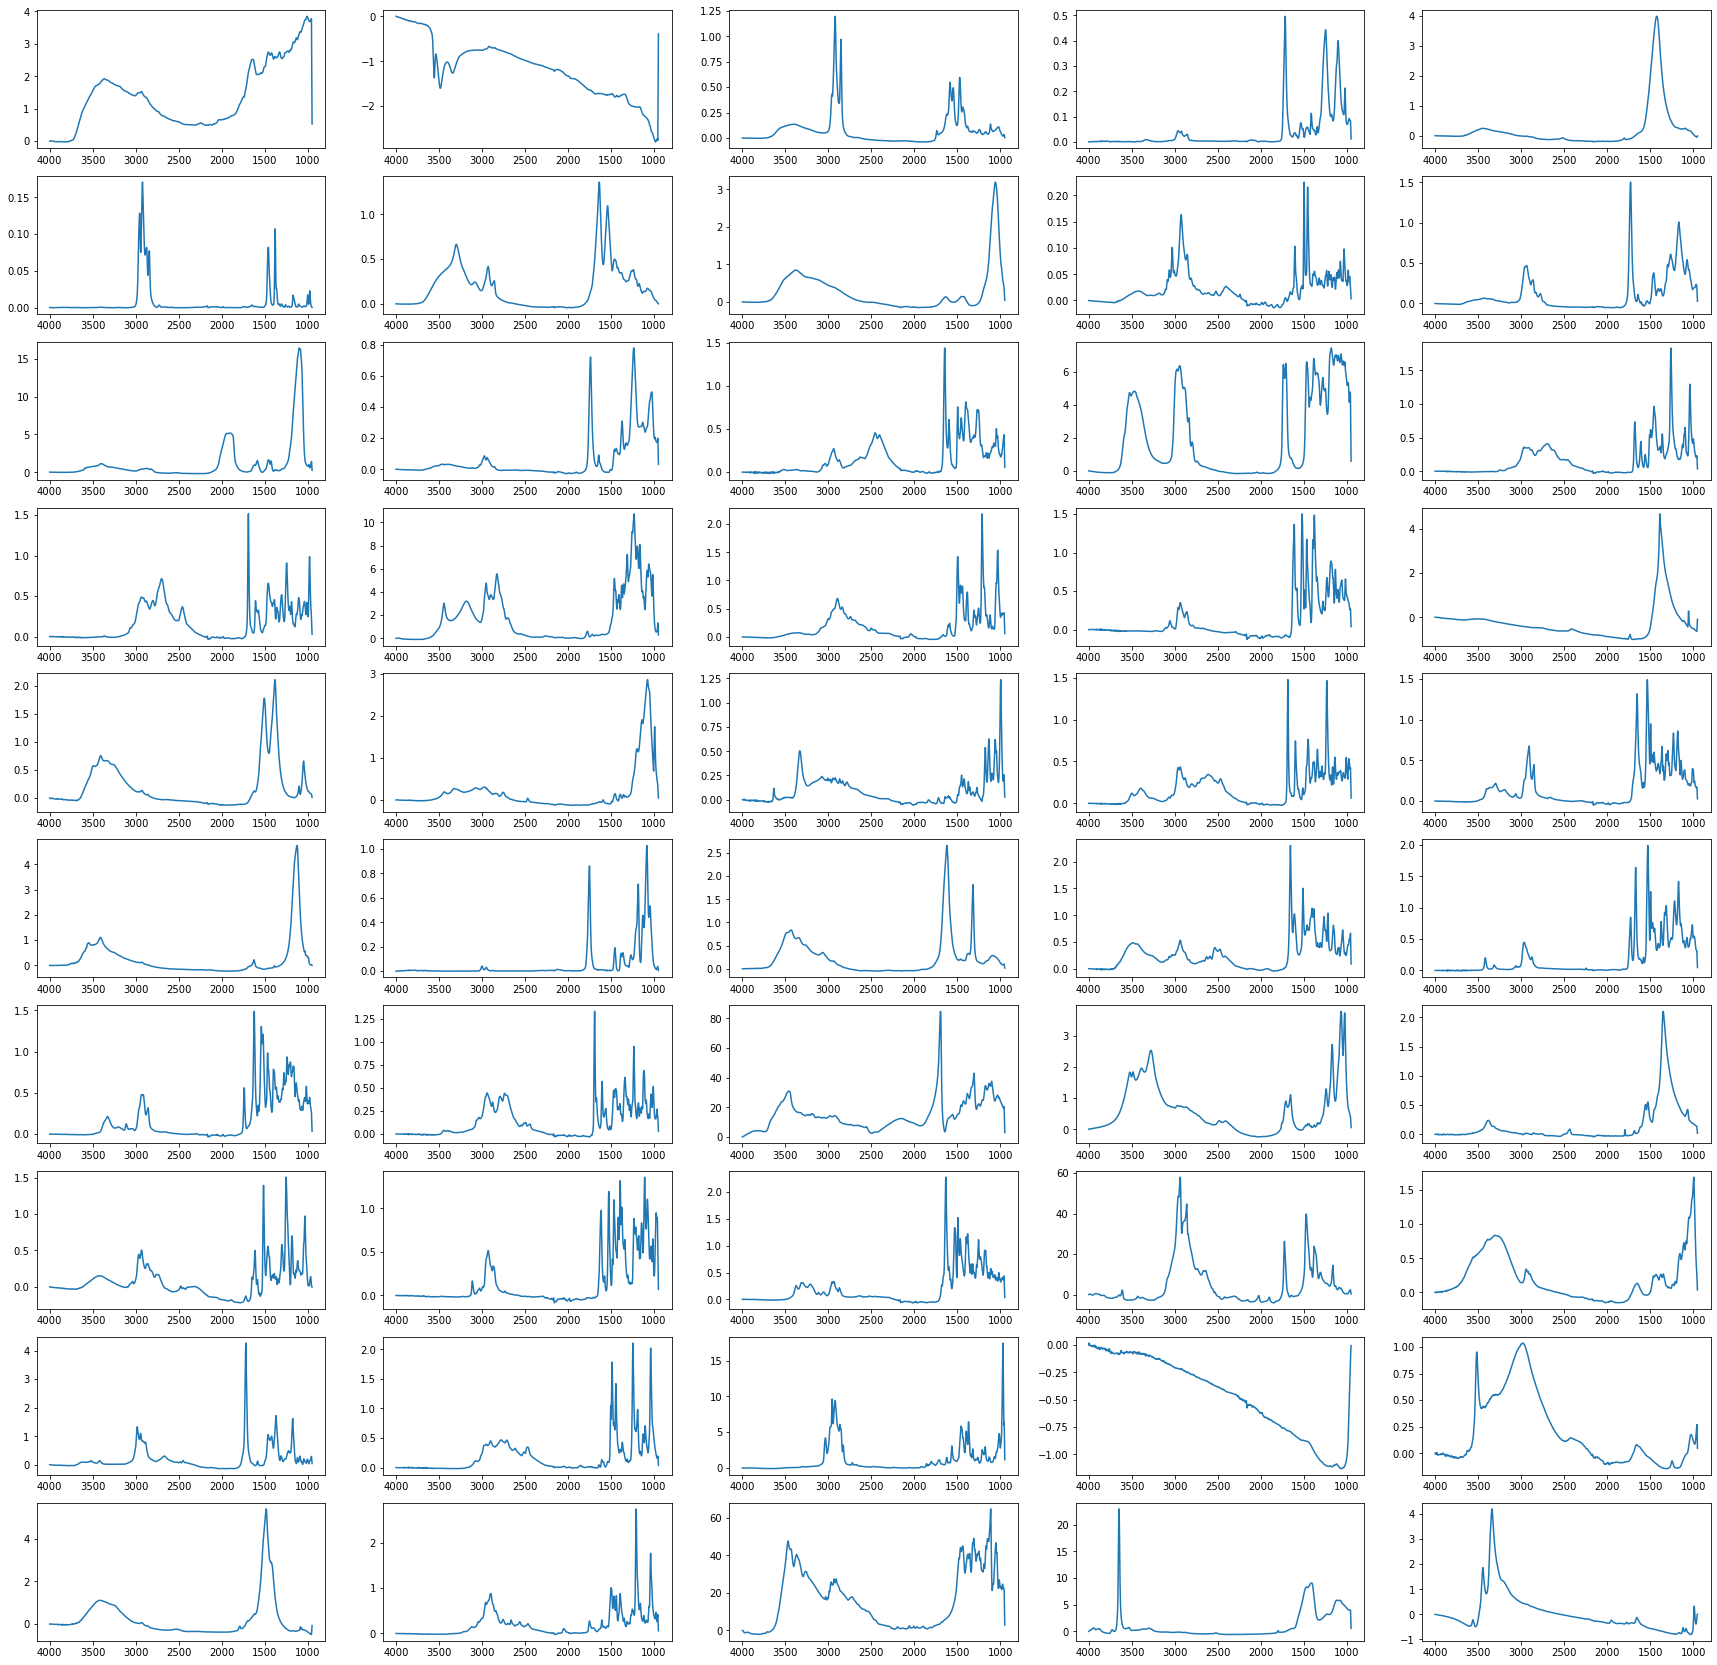

In [14]:
#cl_simplified = pd.read_csv('cluster_keys_simplified.csv')
#simp_key = dict(zip(cl_simplified['index'],cl_simplified['simplified_names']))
fig, axs = plt.subplots(10,5,figsize=(30,30))

for ix in range(10):
    for ix2 in range(5):
        s_ix = ix*5+ix2
        axs[ix,ix2].plot(der_spectra['wavenos'], (cl_means[s_ix]))
        #axs[ix,ix2].fill_between(der_spectra['wavenos'], (np.array(cl_means[s_ix])-.5*np.array(cl_stds[s_ix])),
        #    (np.array(cl_means[s_ix]) + .5*np.array(cl_stds[s_ix])), alpha = .4)
        #ft_sp, ft_nm, ft_id = lib_p.library_fit_1(deriv(cl_means[s_ix],smoothing_window),der_spectra['wavenos'],s_ix)[1:4]
        #integ_bf_spec = integ(ft_sp['spectrum'])
        #nmz_bf = np.max(integ_bf_spec) - np.min(integ_bf_spec)
        #axs[ix,ix2].plot(ft_sp['wavenumbers'], integ_bf_spec/nmz_bf, label = lib_p.catID(ft_id))
        #axs[ix,ix2].text(2700,1.7,'Cluster '+str(s_ix+1)+'\n'+str(s_ix+1), fontsize=12)
        axs[ix,ix2].invert_xaxis()

plt.savefig('ftir_clusters_raw.png',bbox_inches='tight')


In [42]:

#print(d)
#len(set(clust_ix_raw))
#print(clust_dict)
OS_metadata[OS_metadata['clust_ix']==1]['SpectrumID']

437     Infrared/Processed/Ankerite__R050181-1__Infrar...
449     Infrared/Processed/Aragonite__R040078-1__Infra...
487     Infrared/Processed/Barytocalcite__R050288-1__I...
488     Infrared/Processed/BastnasiteCe__R050409-1__In...
493     Infrared/Processed/Benstonite__R050484-1__Infr...
                              ...                        
2818    Strontianite__R050476-1__Infrared__Infrared_Da...
2819    Strontianite__R050564-1__Infrared__Infrared_Da...
2952    Witherite__R040040-1__Infrared__Infrared_Data_...
2953    Witherite__R050148-1__Infrared__Infrared_Data_...
2954    Witherite__R050267-1__Infrared__Infrared_Data_...
Name: SpectrumID, Length: 112, dtype: object


In [50]:
OS_metadata[OS_metadata['SpectrumIdentity'].str.contains('Acrylic') | OS_metadata['SpectrumIdentity'].str.contains('acrylic')]['clust_ix']

1339      3
1341      3
1380     10
1382     10
1449     14
1632     12
1635     12
2083    166
3815     12
3816     12
3817     12
3818     12
3819     12
3820     12
Name: clust_ix, dtype: int32

In [53]:
OS_metadata[OS_metadata['clust_ix']==14]['SpectrumIdentity']

272                                  Erythromycin
1289                                        amber
1397               methyl vinyl ether maleic acid
1398          methyl vinyl ether maleic anhydride
1446            poly(2 hydroxyethyl methacrylate)
1449                           poly(acrylic acid)
1670                           dammar - damar gum
1671            drachenblut - dragons blood resin
1680                     ketonharz - ketone resin
1684                                kopal - copal
1685                              mastix - mastic
1697                          schellack - shellac
1702                Amber (Baltic; A. Nissenbaum)
1703          Amber (Chiapas; Dominican Republic)
1704    Amber (Dominican Republic; A. Nissenbaum)
1705        Amber (Hermon, Israel; A. Nissenbaum)
1706            Amber (New Jersey; A. Nissenbaum)
1751              Bitumen (Oman 1927; Nissenbaum)
1813           Copal (Philippines; A. Nissenbaum)
1996                       Res 11 Boswellia Sacra


(-1e-20, 1e-20)

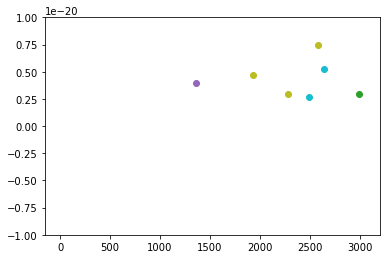

In [ ]:
plt.plot(np.transpose(Xp),'o')
plt.ylim([-10**-20,10**-20])

In [ ]:
OS_library = OS_library.sort_values(by=['sample_name','wavenumber'])


In [ ]:
OS_library[OS_library['sample_name']=='43d59f296a3208e872a5b05cfbe63c39']

,wavenumber,intensity,sample_name
121,900.6088,-4.575128,43d59f296a3208e872a5b05cfbe63c39
122,902.5373,-4.575126,43d59f296a3208e872a5b05cfbe63c39
123,904.4658,-4.575124,43d59f296a3208e872a5b05cfbe63c39
124,906.3943,-4.575120,43d59f296a3208e872a5b05cfbe63c39
125,908.3228,-4.575119,43d59f296a3208e872a5b05cfbe63c39
...,...,...,...
1295,3164.6660,-4.575161,43d59f296a3208e872a5b05cfbe63c39
1296,3166.5940,-4.575161,43d59f296a3208e872a5b05cfbe63c39
1297,3168.5230,-4.575161,43d59f296a3208e872a5b05cfbe63c39
1298,3170.4510,-4.575160,43d59f296a3208e872a5b05cfbe63c39


In [10]:
clust_dict

{270: 1,
 25: 2,
 219: 3,
 272: 4,
 442: 5,
 218: 6,
 409: 7,
 264: 8,
 307: 9,
 245: 10,
 337: 11,
 249: 12,
 298: 13,
 242: 14,
 362: 15,
 179: 16,
 399: 17,
 390: 18,
 353: 19,
 24: 20,
 445: 21,
 197: 22,
 198: 23,
 173: 24,
 419: 25,
 336: 26,
 329: 27,
 412: 28,
 313: 29,
 418: 30,
 350: 31,
 178: 32,
 206: 33,
 263: 34,
 187: 35,
 345: 36,
 352: 37,
 410: 38,
 243: 39,
 195: 40,
 340: 41,
 369: 42,
 290: 43,
 23: 44,
 269: 45,
 26: 46,
 391: 47,
 335: 48,
 446: 49,
 190: 50,
 285: 51,
 212: 52,
 407: 53,
 153: 54,
 234: 55,
 254: 56,
 320: 57,
 321: 58,
 137: 59,
 246: 60,
 134: 61,
 260: 62,
 280: 63,
 430: 64,
 33: 65,
 328: 66,
 27: 67,
 222: 68,
 156: 69,
 132: 70,
 444: 71,
 196: 72,
 342: 73,
 319: 74,
 274: 75,
 326: 76,
 343: 77,
 359: 78,
 176: 79,
 368: 80,
 316: 81,
 140: 82,
 347: 83,
 271: 84,
 251: 85,
 284: 86,
 265: 87,
 231: 88,
 244: 89,
 334: 90,
 383: 91,
 277: 92,
 325: 93,
 355: 94,
 402: 95,
 259: 96,
 417: 97,
 133: 98,
 210: 99,
 365: 100,
 302: 101,
 30